# Looking at cell2location mapping of in vitro trophoblast cell states onto 4 main chips of donor P13

Here:

- 13.01.2022 run: using all cleaned up genes (9447, both by CCG and LF filtering) and final_annot_v8 annotation, with `run_regression` method and mRNA-aligned Visium

01.2022

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_root/build_artifac

# Reading in Visium data for donor P13

In [20]:
# reading adatas for scanpy plotting
IDs_P13 = ['64','65','66','67']

adatas_P13 = {}

for ID in IDs_P13:
    print(ID)
    # pre-mRNA
    adatas_P13[ID] = sc.read_visium('/lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_34914_WS_PLA_S91017' + ID + '_GRCh38-3_0_0-premrna/')
    adatas_P13[ID].var_names_make_unique()

reading /lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_34914_WS_PLA_S9101764_GRCh38-3_0_0-premrna/filtered_feature_bc_matrix.h5


64


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_34914_WS_PLA_S9101765_GRCh38-3_0_0-premrna/filtered_feature_bc_matrix.h5


65


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_34914_WS_PLA_S9101766_GRCh38-3_0_0-premrna/filtered_feature_bc_matrix.h5


66


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /lustre/scratch117/cellgen/team292/aa22/data/202008_MFI_Visium/20200901_new_data_spaceranger110/spaceranger110_count_34914_WS_PLA_S9101767_GRCh38-3_0_0-premrna/filtered_feature_bc_matrix.h5


67


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
# adding QC metrics to the visium objects
for ID in IDs_P13:
    adatas_P13[ID].obs['n_counts'] = adatas_P13[ID].X.sum(1)
    adatas_P13[ID].obs['log_counts'] = np.log(adatas_P13[ID].obs['n_counts'])
    adatas_P13[ID].obs['n_genes'] = (adatas_P13[ID].X > 0).sum(1)
    
    mito_genes = [name for name in adatas_P13[ID].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    adatas_P13[ID].obs['percent_mito'] = np.sum(
        adatas_P13[ID][:, mito_genes].X, axis=1).A1 / np.sum(adatas_P13[ID].X, axis=1).A1
    # saving raw counts in .raw for now
    adatas_P13[ID].raw = adatas_P13[ID].copy()

In [22]:
adatas_P13['64']

AnnData object with n_obs × n_vars = 3568 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'log_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Reading in cell2location results

latest run with the most up-to-date cell2location environment and tutorial

using mRNA aligned Visium

with soupy gene filtering (LF approach) and CCG filtering in the organoids object

and 30 cells/spot - may be too much (?)

In [8]:
# 13.01.2022 run: using all cleaned up genes (9447, both by CCG and LF filtering) and final_annot_v8 annotation, with run_regression method and mRNA-aligned Visium
path = '/lustre/scratch117/cellgen/team292/aa22/cell2loc_files/in_vitro_onto_in_vivo_mapping/results/20220113_nonact_organoids_final_annot_v8_onto_main_P13_Visium_chips_with_LF_gene_filter_and_run_regression/cell2location_map/'

# object with all used Visium chips concatenated (in this case 4 main Visium chips)
sp_mapping = sc.read(path + 'sp.h5ad')



In [9]:
sp_mapping

AnnData object with n_obs × n_vars = 15488 × 9447
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'barcode_sample', 'batch', 'spotID', '_scvi_batch', '_scvi_labels', '_indices'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [23]:
for ID in IDs_P13:
    print(ID)
    adatas_P13[ID].obs.index = [idx + '_34914_WS_PLA_S91017' + ID for idx in adatas_P13[ID].obs.index]

64
65
66
67


In [24]:
len(set(adatas_P13['64'].obs_names) & set(sp_mapping.obsm['q05_cell_abundance_w_sf'].index))

3568

In [25]:
for ID in IDs_P13:
    print(ID)
    for col in sp_mapping.obsm['q05_cell_abundance_w_sf']:
        col_chopped = col[18:]
        adatas_P13[ID].obs[col_chopped] = sp_mapping.obsm['q05_cell_abundance_w_sf'].loc[adatas_P13[ID].obs_names, col]

64
65
66
67


In [26]:
c2l_tags = [elem for elem in adatas_P13['64'].obs.columns if 'w_sf_' in elem]
c2l_tags

['w_sf_EVT',
 'w_sf_EVT_early',
 'w_sf_SCT',
 'w_sf_VCT',
 'w_sf_VCT_CCC',
 'w_sf_VCT_fusing',
 'w_sf_iEVT']

64


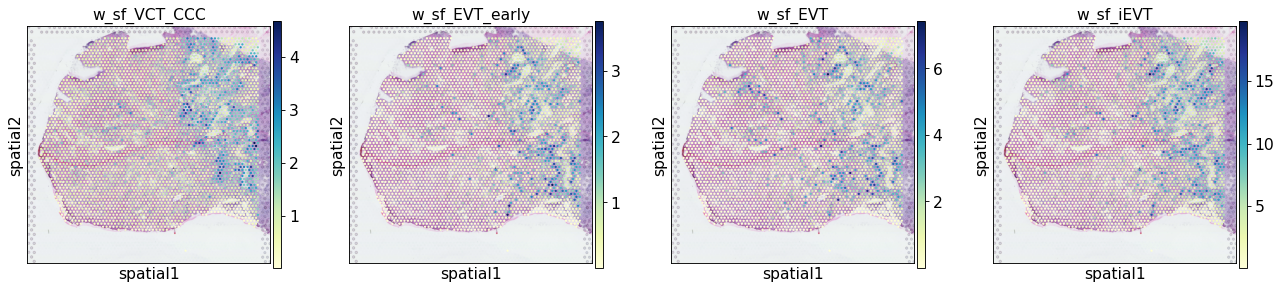

65


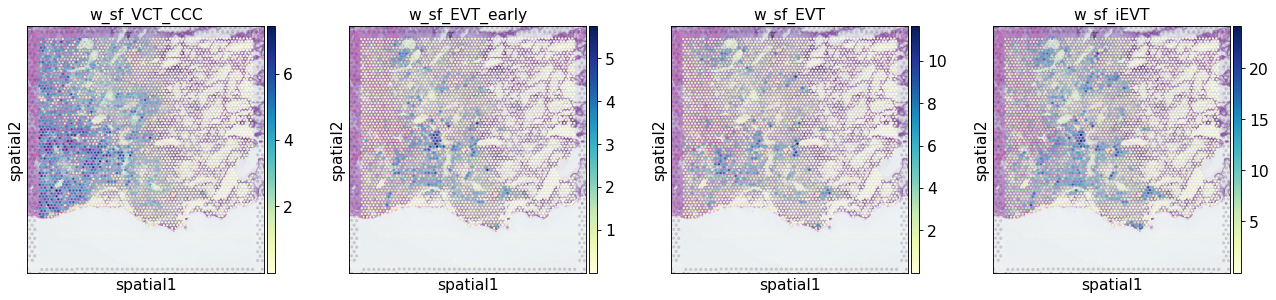

66


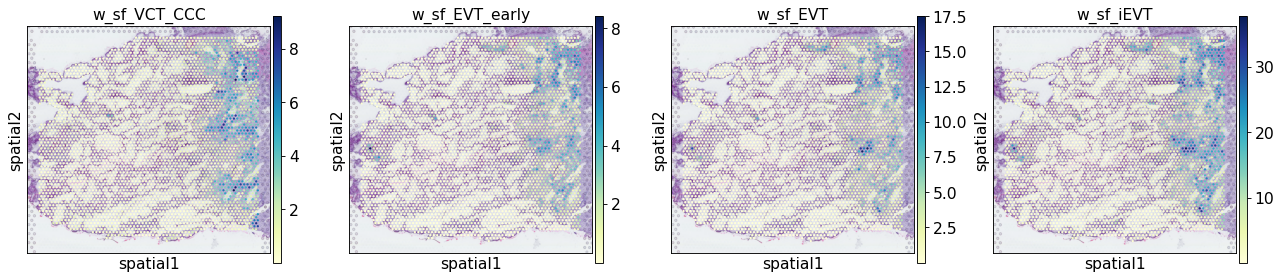

67


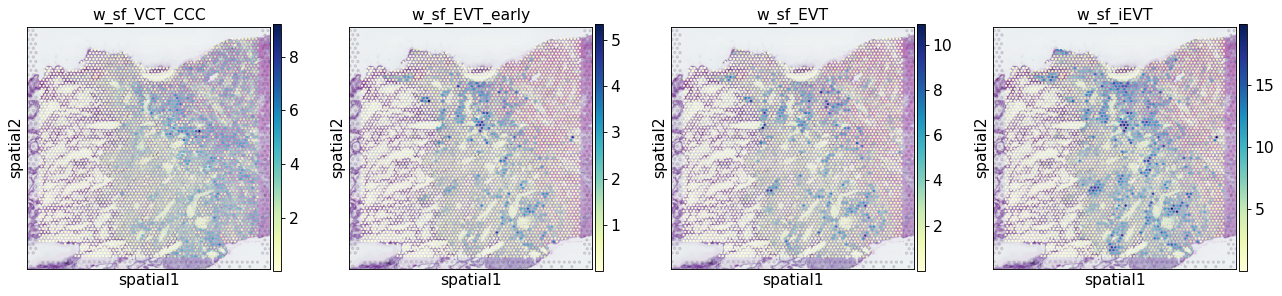

In [29]:
# plot

for ID in IDs_P13:
    print(ID)
    sc.pl.spatial(adatas_P13[ID],
                 color = ['w_sf_VCT_CCC',
                          'w_sf_EVT_early',
                          'w_sf_EVT',
                          #'w_sf_SCT','w_sf_VCT','w_sf_VCT_fusing',
                          'w_sf_iEVT'], cmap='YlGnBu')

### Reading in cell2location results

latest run with the most up-to-date cell2location environment and tutorial

using mRNA aligned Visium

with soupy gene filtering (LF approach) and CCG filtering in the organoids object

and 30 cells/spot - may be too much (?)

In [30]:
# 13.01.2022 run: using HVGs (2000, after CCG and LF filtering) and final_annot_v8 annotation, with run_regression method and mRNA-aligned Visium
path = '/lustre/scratch117/cellgen/team292/aa22/cell2loc_files/in_vitro_onto_in_vivo_mapping/results/20220113_nonact_organoids_final_annot_v8_HVG_subsetted_onto_main_P13_Visium_chips_with_LF_gene_filter_and_run_regression/cell2location_map/'

# object with all used Visium chips concatenated (in this case 4 main Visium chips)
sp_mapping = sc.read(path + 'sp.h5ad')



In [31]:
sp_mapping

AnnData object with n_obs × n_vars = 15488 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'barcode_sample', 'batch', 'spotID', '_scvi_batch', '_scvi_labels', '_indices'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [32]:
for ID in IDs_P13:
    print(ID)
    # already done somewhere above
    #adatas_P13[ID].obs.index = [idx + '_34914_WS_PLA_S91017' + ID for idx in adatas_P13[ID].obs.index]

64
65
66
67


In [33]:
len(set(adatas_P13['64'].obs_names) & set(sp_mapping.obsm['q05_cell_abundance_w_sf'].index))

3568

In [34]:
for ID in IDs_P13:
    print(ID)
    for col in sp_mapping.obsm['q05_cell_abundance_w_sf']:
        col_chopped = col[18:]
        adatas_P13[ID].obs[col_chopped + '_hvg'] = sp_mapping.obsm['q05_cell_abundance_w_sf'].loc[adatas_P13[ID].obs_names, col]

64
65
66
67


In [35]:
c2l_tags = [elem for elem in adatas_P13['64'].obs.columns if 'w_sf_' in elem]
c2l_tags

['w_sf_EVT',
 'w_sf_EVT_early',
 'w_sf_SCT',
 'w_sf_VCT',
 'w_sf_VCT_CCC',
 'w_sf_VCT_fusing',
 'w_sf_iEVT',
 'w_sf_EVT_hvg',
 'w_sf_EVT_early_hvg',
 'w_sf_SCT_hvg',
 'w_sf_VCT_hvg',
 'w_sf_VCT_CCC_hvg',
 'w_sf_VCT_fusing_hvg',
 'w_sf_iEVT_hvg']

64


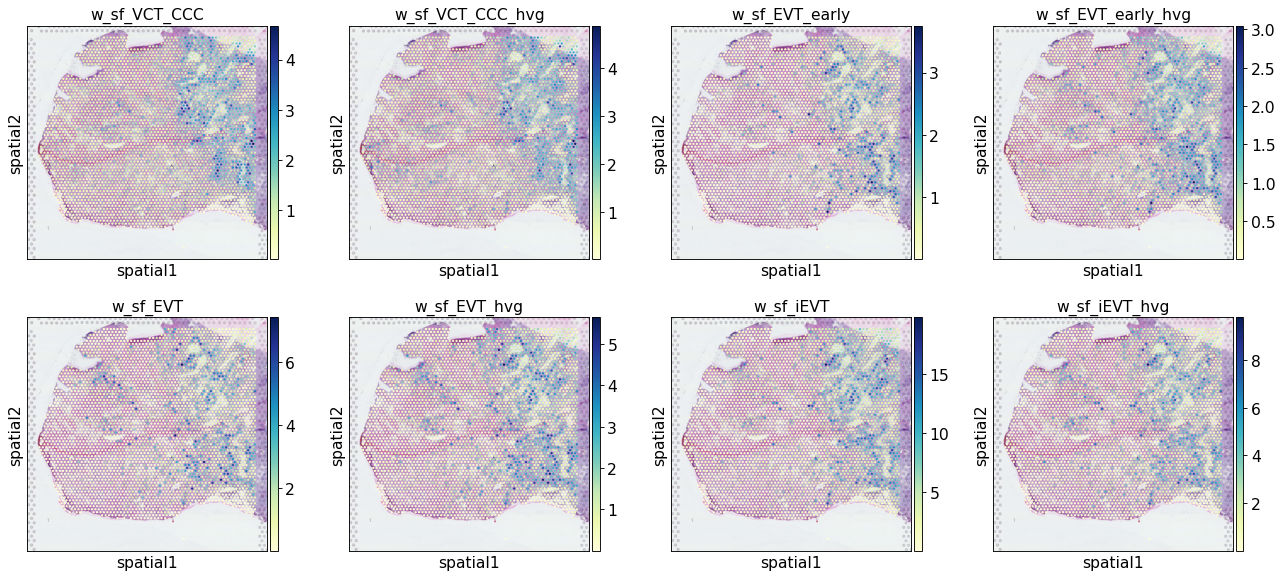

65


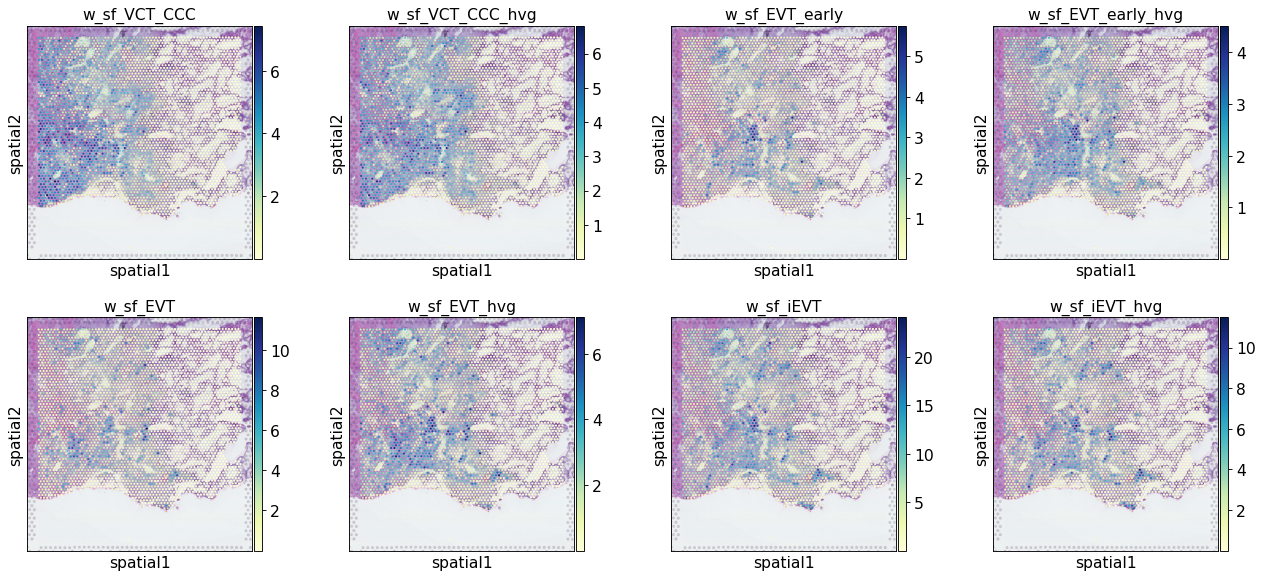

66


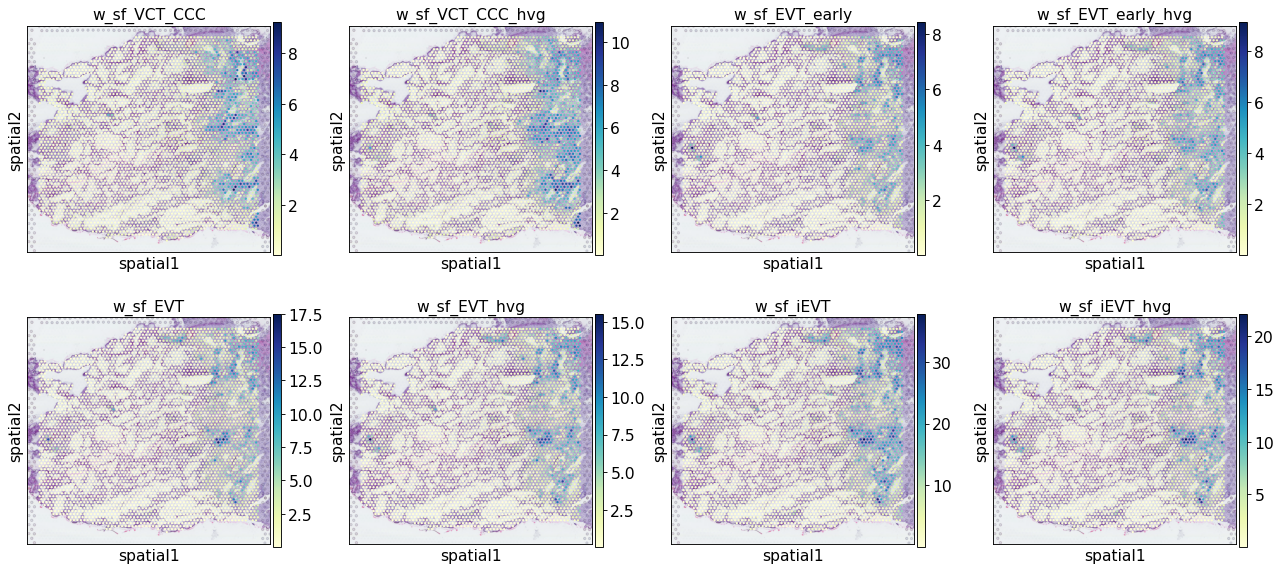

67


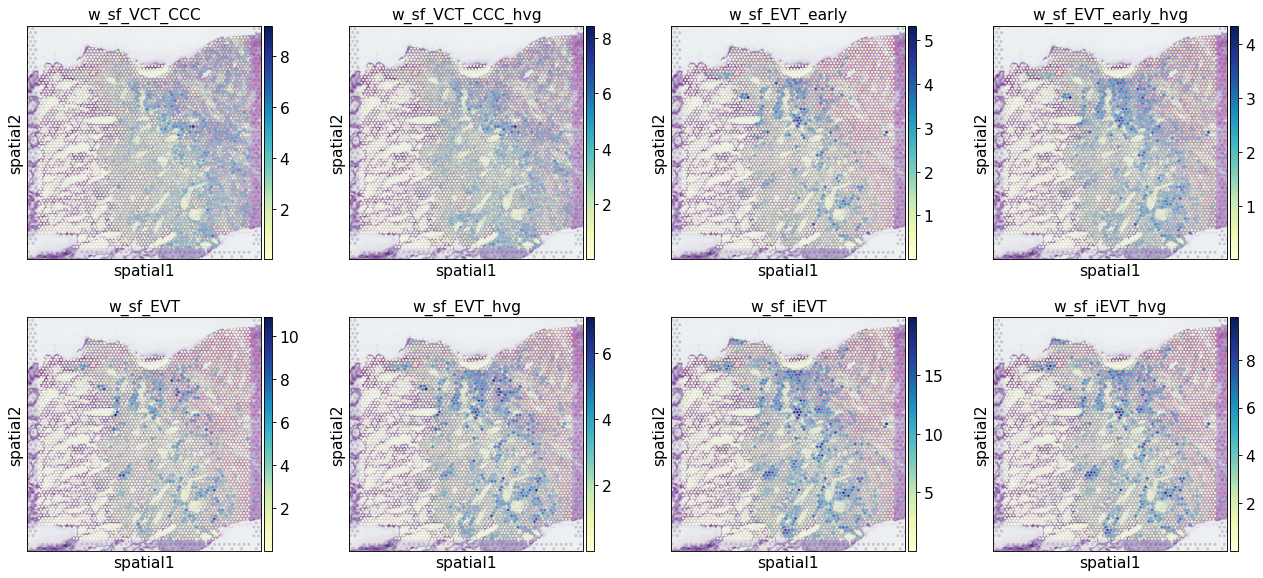

In [36]:
# plot

for ID in IDs_P13:
    print(ID)
    sc.pl.spatial(adatas_P13[ID],
                 color = ['w_sf_VCT_CCC', 'w_sf_VCT_CCC_hvg',
                          'w_sf_EVT_early', 'w_sf_EVT_early_hvg',
                          'w_sf_EVT', 'w_sf_EVT_hvg',
                          #'w_sf_SCT','w_sf_VCT','w_sf_VCT_fusing',
                          'w_sf_iEVT', 'w_sf_iEVT_hvg'], cmap='YlGnBu')

## going to use the run with all cleaned up genes (9447)